## Setup

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from tqdm.notebook import trange
from Utils.utils import *
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from copy import deepcopy
import seaborn as sns

c:\Users\luis\Documents\workspace\ic\CTAI-IC_Ciencia_de_Dados\Artigo_Estudo_Realimentacao\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
gpus = tf.config.list_physical_devices('GPU')

if (len(gpus) > 0):
    tf.config.set_visible_devices(gpus[1], 'GPU')
    tf.config.get_visible_devices('GPU')

## Global Variables

### Path

In [4]:
DATA_PATH = './data'
MODELS_PATH = './models'
LOGS_PATH = './logs'
PLOTS_PATH = './plots'
PREDICTIONS_PATH = './predictions'
ERRORS_PATH = './errors_table'

### Predictors and Target

In [5]:
PREDICTORS = ['pressao_na_choke', 'abertura_valvula_pneumatica', 'frequencia']
TARGET = 'pressao_na_choke'

### Data

In [6]:
DF = pd.read_parquet(os.path.join(DATA_PATH, 'lea_data_resampled.parquet')).resample('10s').ffill().dropna(how='all')
NORMALIZED_DF = normalize_df(DF, PREDICTORS)

#### Train and Evaluate Periods

In [7]:

PERIODS = {"treino":None, "validacao":None}

        
PERIODS["treino"] = [
    ['2021-09-17 23:14', '2021-09-17 23:28'],
    ['2021-09-18 05:14', '2021-09-18 05:28'],
    ['2021-09-18 11:15', '2021-09-18 11:29'],
    ['2021-09-18 17:15', '2021-09-18 17:29'],
    ['2021-09-18 23:15', '2021-09-18 23:29'],
    ['2021-09-19 05:14', '2021-09-19 05:28'],
]

PERIODS["validacao"] = [
    ['2021-09-19 11:15', '2021-09-19 11:29'],
    ['2021-09-19 17:14', '2021-09-19 17:28'],
]

PERIODS["teste"] = [
    ["2021-09-19 23:15", "2021-09-19 23:30"],
    ["2021-09-20 05:15", "2021-09-20 05:30"],
    ["2021-09-19 23:15", "2021-09-20 05:30"],
]

#### Presentation

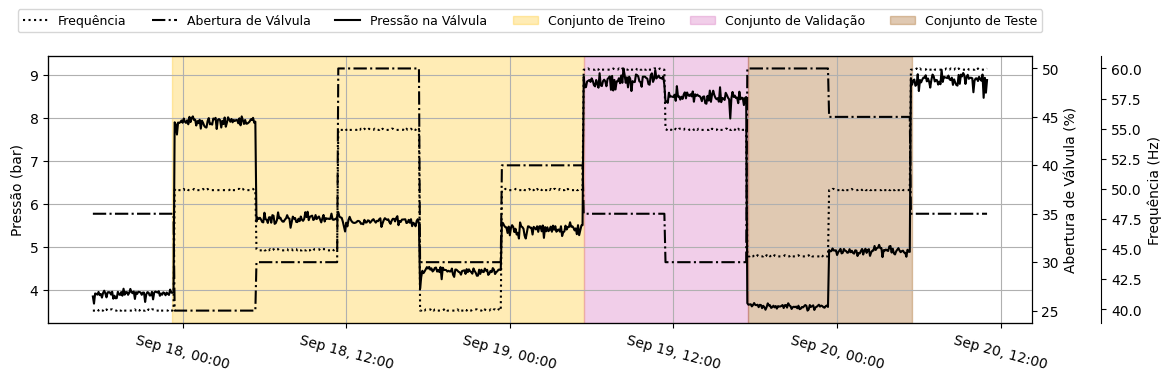

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
target = DF[PREDICTORS].resample('5min').ffill()

pressure_color = (0,0,0)
valve_color = (0,0,0)
frequency_color = (0,0,0)
train_period_color = np.divide(np.array([255,194,10]), 255)
val_period_color = np.divide(np.array([211,95,183]), 255)
test_period_color = np.divide(np.array([153,79,0]), 255)
axs = []
ax2 = ax.twinx()
ax3 = ax.twinx()

axs.append(ax3.plot(target['frequencia'], linestyle=':', color = frequency_color, label = 'Frequência')[0])
axs.append(ax2.plot(target['abertura_valvula_pneumatica'], linestyle='-.', color = valve_color, label = 'Abertura de Válvula')[0])
axs.append(ax.plot(target['pressao_na_choke'], linestyle='-', color = pressure_color, label = 'Pressão na Válvula')[0])

ax.set_ylabel('Pressão (bar)', color = (0,0,0))
ax2.set_ylabel('Abertura de Válvula (%)', color = valve_color)
ax3.set_ylabel('Frequência (Hz)', color = frequency_color)

ax2.tick_params(axis='y', colors = valve_color)
ax3.tick_params(axis='y', colors = frequency_color)

ax3.spines['right'].set_position(('outward', 50))  # Adjust position

ax.grid()
ax.tick_params(axis='x', labelsize=10, rotation=-15)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))

axs.append(ax.axvspan( PERIODS['treino'][0][0], PERIODS['treino'][-1][1], color=train_period_color, alpha=0.3, label='Conjunto de Treino'))


axs.append(ax.axvspan(PERIODS['treino'][-1][1], PERIODS['validacao'][-1][1], color=val_period_color, alpha=0.3, label='Conjunto de Validação'))

axs.append(ax.axvspan(PERIODS['validacao'][-1][1], PERIODS['teste'][-1][1], color=test_period_color, alpha=0.3, label='Conjunto de Teste'))

labels = [line.get_label() for line in axs]

ax.legend(axs, labels, loc='upper center', bbox_to_anchor=(0.49, 1.2), ncol=6, fontsize=9)
plt.tight_layout()
plt.savefig("figures/dataset.png", dpi=600)  # 300 is a common high-res value
plt.show()

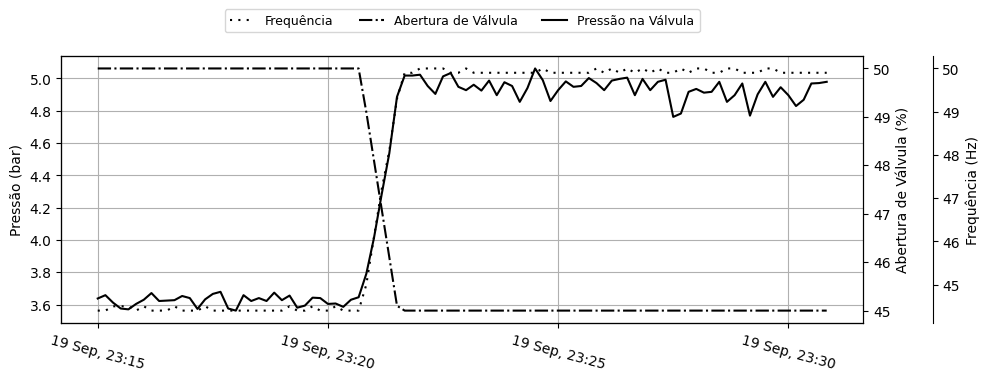

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10, 4))
target = DF[PERIODS['teste'][0][0]:PERIODS['teste'][0][1]][PREDICTORS]

pressure_color = (0,0,0)
valve_color = pressure_color
frequency_color = pressure_color

axs = []
ax2 = ax.twinx()
ax3 = ax.twinx()

axs.append(ax3.plot(target['frequencia'], linestyle=(0, (1, 3)), color=frequency_color, label='Frequência')[0])
axs.append(ax2.plot(target['abertura_valvula_pneumatica'], linestyle='-.', color=valve_color, label='Abertura de Válvula')[0])
axs.append(ax.plot(target['pressao_na_choke'], linestyle='-', color=pressure_color, label='Pressão na Válvula')[0])

ax.set_ylabel('Pressão (bar)', color=pressure_color)
ax2.set_ylabel('Abertura de Válvula (%)', color=valve_color)
ax3.set_ylabel('Frequência (Hz)', color=frequency_color)

ax2.tick_params(axis='y', colors=valve_color)
ax3.tick_params(axis='y', colors=frequency_color)

ax3.spines['right'].set_position(('outward', 50))  # Ajusta a posição

labels = [line.get_label() for line in axs]

ax.legend(axs, labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=6, fontsize=9)
ax.tick_params(axis='x', labelsize=10, rotation=-15)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b, %H:%M'))
ax.grid()
plt.tight_layout()
plt.show()

## Functions

In [10]:
class highest_absolute_error(tf.keras.metrics.Metric):
    def __init__(self, name="hae", **kwargs):
        super(highest_absolute_error, self).__init__(name=name, **kwargs)
        self.max_abs_value = self.add_weight(name="max_abs", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        abs_values = tf.abs(y_true - y_pred)
        batch_max = tf.reduce_max(abs_values)
        self.max_abs_value.assign(tf.maximum(self.max_abs_value, batch_max))

    def result(self):
        return self.max_abs_value

    def reset_state(self):
        self.max_abs_value.assign(0.0)


In [11]:
def model_builder(neurons, layer ='LSTM', optimizer_str:str='Nadam', loss:str='mean_squared_error',
                   metrics:list=['mae',  'mse', 'mape', highest_absolute_error()]
                   ) -> tf.keras.Model:
        model = tf.keras.Sequential()

        layer_class = getattr(tf.keras.layers, layer)

        model.add(layer_class(units=neurons, input_shape=[None, 3]))
        model.add(tf.keras.layers.Dense(1))
    
        optimizer_class = getattr(tf.keras.optimizers, optimizer_str)
        optimizer = optimizer_class()

        model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics = metrics
        )
        return model

In [12]:
def plot_train_curves(history:pd.DataFrame, ax, title):

    ax.set_ylim([0, 0.1])
    ax.set_xlabel('Epoch')
    ax.set_title(title, fontsize=11, pad=10)
    ax.plot(history['mae'], label = 'MAE')
    ax.plot(history['val_mae'], label = 'Validation MAE')

    min_mae = history['mae'].min()
    min_val_mae = history['val_mae'].min()

    xindex = history['mae'].idxmin()
    ax.annotate(f'min mae: {min_mae:.4f}', xy = (xindex, history['mae'].min()), 
        xytext =(xindex, history['mae'].min()*2),
        arrowprops = dict(facecolor ='blue', 
                        arrowstyle='->', relpos=(0.3,0.5)),
        fontsize=7)

    xxindex = history['val_mae'].idxmin()
    ax.annotate(f'min val: {min_val_mae:.4f}', xy = (xxindex, history['val_mae'].min()), 
        xytext =(xxindex, history['val_mae'].min()*2),
        arrowprops = dict(facecolor ='orange', 
                        arrowstyle='->', relpos=(0.3,0.5)),
        fontsize=7)
    ax.legend(loc="upper right")
    ax.grid()



In [13]:
def multi_step_prediction_and_plot(
                df:pd.DataFrame, variables:list, target:str, seq_length:int, 
                model:tf.keras.Model, prediction_period:list, prediction_path:str, 
                title:str, ax) -> pd.DataFrame:

    prediction = multi_step_prediction(model, df, variables, target, seq_length, prediction_period)
    erro = mean_absolute_error(prediction['real'], prediction['predicted'])
    prediction.to_json(os.path.join(prediction_path, f'{title}_prediction.json'))

    ax.set_title(f"{title} MAE:{erro:.4f}", pad=10, fontsize=9)
    ax.plot(prediction['real'], label = 'real')
    ax.plot(prediction['predicted'], label = 'predicted')
    ax.legend(loc="upper left")
    ax.grid()
    ax.tick_params(axis='x', labelsize=10, rotation=-15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))

    return prediction

            

In [14]:
def predict(model, df, periodo, seq_length, target, mode='Direct'):
    target_df = df.loc[periodo[0] : periodo[1]]
    
    x = tf.keras.utils.timeseries_dataset_from_array(
        target_df.to_numpy(),
        targets=None,
        sequence_length=seq_length,
        batch_size=1
    )
    n_predictions = len(target_df) - seq_length + 1
    predictions = np.zeros(n_predictions)

    if(mode == "Direct"):
        prediction = model.predict(x, verbose=1)
        predictions[:] = prediction[:,0]

    elif(mode == 'Recursive'):
        x = np.array(list(x.as_numpy_iterator()))
        for i in trange(n_predictions):
            if (i > 0):
                x[i][0, :-1, 0] = x[i - 1][0, 1:, 0]
                x[i][0, -1, 0] = predictions[i - 1]

            prediction = model.predict(x[i], verbose=0)
            predictions[i] = prediction[0, 0]

    idx = df.loc[periodo[0]:].index[seq_length:seq_length+n_predictions]
    return pd.DataFrame({"real" : df.loc[idx, target], 'predicted' : predictions}, index=idx)

In [15]:
def desnormalize_prediction(prediction, y_real):
    y_min, y_max = y_real.min(), y_real.max()
    prediction['predicted'] = (prediction['predicted'] * (y_max - y_min)) + y_min
    prediction['real'] = (prediction['real'] * (y_max - y_min)) + y_min
    return prediction

In [16]:
def plot_prediction(prediction, mae, title, ax):
    ax.set_title(f"{title} MAE:{mae:.4f}", fontsize=10)
    ax.plot(prediction['real'], label = 'real')
    ax.plot(prediction['predicted'], label = 'predicted')
    ax.tick_params(axis='x', labelsize=10, rotation=-15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))
    ax.legend(loc="upper left")
    ax.grid()


## Train Global Variables

In [17]:
loss_functions = {
    'mae' : tf.keras.losses.MeanAbsoluteError(name='mae'),
    'mse' : tf.keras.losses.MeanSquaredError(name='mse'),
    'huber' : tf.keras.losses.Huber(name="huber")
}
layer_sizes = [8, 16, 24, 32, 40, 48]
batch_sizes = [8, 16, 32, 64, 96, 128, 160, 192]

In [18]:
SHUFFLE = True
SEED = 42
SEQ_LENGTH=15
EPOCHS = 10000
PATIENCE = 300
TRAIN_TYPE = '15min'
MONITOR = 'val_mae'
METRICS = [
    tf.keras.losses.MeanAbsoluteError(name='mae'),
    tf.keras.losses.MeanSquaredError(name='mse'),
    tf.keras.losses.MeanAbsolutePercentageError(name='mape'),
    highest_absolute_error()
]

In [19]:
base = {loss : {layer_size : {} for layer_size in layer_sizes} for loss in loss_functions}

models = deepcopy(base)
historys = deepcopy(base)
errors = deepcopy(base)


In [20]:
id_columns = [('','','Loss'), ('','','Neurons',), ('','','BatchSize',)]

train_val_keys = ['Train', 'Validation']
metrics = ['MAE', 'MSE', 'HAE', 'MAPE']
periods = ['T1', 'T2', 'T3']
pred_types = ['Direct', 'Recursive']

global_cols = [('', tv, metric) for tv in train_val_keys for metric in metrics]
pred_cols = [(p, pt, m) for p in periods for pt in pred_types for m in metrics]

all_cols = id_columns + global_cols + pred_cols
multi_index = pd.MultiIndex.from_tuples(all_cols)

df = pd.DataFrame(columns=multi_index)

### Build and Fit Models

In [21]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                                                                monitor=MONITOR,
                                                                patience=PATIENCE,
                                                                restore_best_weights=True,
                                                                mode='min')
                
callbacks = [earlystopping_callback]

## MAE as Loss Function

In [22]:
loss = loss_functions['mae']

In [23]:

for layer_size in layer_sizes:
    for batch_size in batch_sizes:
    
        filename = f'{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize'
        model_path = f'{os.path.join(MODELS_PATH, filename)}.h5'
        history_path = f'{os.path.join(LOGS_PATH, filename)}.json'

        if(os.path.exists(model_path) and os.path.exists(history_path)):
            models[loss.name][layer_size][batch_size] = tf.keras.models.load_model(model_path, compile=False)
            historys[loss.name][layer_size][batch_size] = pd.read_json(history_path)
        else:
            print(f'Treinando modelo {filename}.')

            model =  models[loss.name][layer_size][batch_size] = model_builder(neurons=layer_size, loss=loss, metrics=METRICS)
            tf.keras.utils.set_random_seed(SEED)

            train_ds, val_ds = build_ds(NORMALIZED_DF, TARGET, SEQ_LENGTH, PERIODS, shuffle=True, batch_size=batch_size)

            history = model.fit(
                    x=train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=callbacks,
                    verbose=0,
                )
            
            history = historys[loss.name][layer_size][batch_size] = pd.DataFrame(history.history)

            history.to_json(history_path)
            model.save(model_path)

### Fill Train and Validation Metrics

In [24]:
for i, layer_size in enumerate(layer_sizes):
    for j, batch_size in enumerate(batch_sizes):

        history = historys[loss.name][layer_size][batch_size]

        best_model_metrics = history.iloc[history['val_mae'].idxmin()]

        errors[loss.name][layer_size][batch_size] = {
                    ('', '', 'Loss'): loss.name,
                    ('', '', 'Neurons'): layer_size,
                    ('', '', 'BatchSize'): batch_size,

                    ('', 'Train', 'MAE'): best_model_metrics['mae'],
                    ('', 'Train', 'MSE'): best_model_metrics['mse'],
                    ('', 'Train', 'HAE'): best_model_metrics['hae'],
                    ('', 'Train', 'MAPE'): best_model_metrics['mape'],

                    ('', 'Validation', 'MAE'): best_model_metrics['val_mae'],
                    ('', 'Validation', 'MSE'): best_model_metrics['val_mse'],
                    ('', 'Validation', 'HAE'): best_model_metrics['val_hae'],
                    ('', 'Validation', 'MAPE'): best_model_metrics['val_mape'],
        }

### Predictions and Metrics

In [25]:
for layer_size in layer_sizes:
    for batch_size in batch_sizes:
        
        error = errors[loss.name][layer_size][batch_size]

        for i, periodo_teste in enumerate(PERIODS["teste"]):
            for mode in ['Direct', 'Recursive']:

                prediction_path = os.path.join(PREDICTIONS_PATH, f'T{i+1}_{mode}_{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize.json')

                if(os.path.exists(prediction_path)):
                    prediction = pd.read_json(prediction_path)
                else:
                    print(f'Fazendo predição {mode} do modelo {filename} em T{i+1}.')
                    prediction = desnormalize_prediction(
                                        predict(models[loss.name][layer_size][batch_size], NORMALIZED_DF, periodo_teste, SEQ_LENGTH, TARGET, mode=mode),
                                        DF['pressao_na_choke']
                                 )
                    
                    prediction.to_json(prediction_path)
                
                differences = np.abs(prediction['predicted'] - prediction['real'])
                max_absolute_difference = np.max(differences)

                error[(f'T{i+1}', mode, 'MAE')] = mean_absolute_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MSE')] = mean_squared_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MAPE')] = mean_absolute_percentage_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'HAE')] = max_absolute_difference

        df.loc[len(df)] = error

In [26]:
df[df[('', '', 'Loss')] == loss.name].to_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss.name}Loss.xlsx'))

## MSE as Loss Function

In [27]:
loss = loss_functions['mse']

In [28]:

for layer_size in layer_sizes:
    for batch_size in batch_sizes:
    
        filename = f'{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize'
        model_path = f'{os.path.join(MODELS_PATH, filename)}.h5'
        history_path = f'{os.path.join(LOGS_PATH, filename)}.json'

        if(os.path.exists(model_path) and os.path.exists(history_path)):
            models[loss.name][layer_size][batch_size] = tf.keras.models.load_model(model_path, compile=False)
            historys[loss.name][layer_size][batch_size] = pd.read_json(history_path)
        else:
            print(f'Treinando modelo {filename}.')

            model =  models[loss.name][layer_size][batch_size] = model_builder(neurons=layer_size, loss=loss, metrics=METRICS)
            tf.keras.utils.set_random_seed(SEED)

            train_ds, val_ds = build_ds(NORMALIZED_DF, TARGET, SEQ_LENGTH, PERIODS, shuffle=True, batch_size=batch_size)

            history = model.fit(
                    x=train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=callbacks,
                    verbose=0,
                )
            
            history = historys[loss.name][layer_size][batch_size] = pd.DataFrame(history.history)

            history.to_json(history_path)
            model.save(model_path)

### Fill Train and Validation Metrics

In [29]:
for i, layer_size in enumerate(layer_sizes):
    for j, batch_size in enumerate(batch_sizes):

        history = historys[loss.name][layer_size][batch_size]

        best_model_metrics = history.iloc[history['val_mae'].idxmin()]

        errors[loss.name][layer_size][batch_size] = {
                    ('', '', 'Loss'): loss.name,
                    ('', '', 'Neurons'): layer_size,
                    ('', '', 'BatchSize'): batch_size,

                    ('', 'Train', 'MAE'): best_model_metrics['mae'],
                    ('', 'Train', 'MSE'): best_model_metrics['mse'],
                    ('', 'Train', 'HAE'): best_model_metrics['hae'],
                    ('', 'Train', 'MAPE'): best_model_metrics['mape'],

                    ('', 'Validation', 'MAE'): best_model_metrics['val_mae'],
                    ('', 'Validation', 'MSE'): best_model_metrics['val_mse'],
                    ('', 'Validation', 'HAE'): best_model_metrics['val_hae'],
                    ('', 'Validation', 'MAPE'): best_model_metrics['val_mape'],
        }

### Predictions and Metrics

In [30]:
for layer_size in layer_sizes:
    for batch_size in batch_sizes:
        
        error = errors[loss.name][layer_size][batch_size]

        for i, periodo_teste in enumerate(PERIODS["teste"]):
            for mode in ['Direct', 'Recursive']:

                prediction_path = os.path.join(PREDICTIONS_PATH, f'T{i+1}_{mode}_{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize.json')

                if(os.path.exists(prediction_path)):
                    prediction = pd.read_json(prediction_path)
                else:
                    print(f'Fazendo predição {mode} do modelo {layer_size}n_{loss.name}Loss_{batch_size}bSize em T{i+1}.')
                    prediction = desnormalize_prediction(
                                        predict(models[loss.name][layer_size][batch_size], NORMALIZED_DF, periodo_teste, SEQ_LENGTH, TARGET, mode=mode),
                                        DF['pressao_na_choke']
                                 )
                    
                    prediction.to_json(prediction_path)
                
                differences = np.abs(prediction['predicted'] - prediction['real'])
                max_absolute_difference = np.max(differences)

                error[(f'T{i+1}', mode, 'MAE')] = mean_absolute_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MSE')] = mean_squared_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MAPE')] = mean_absolute_percentage_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'HAE')] = max_absolute_difference

        df.loc[len(df)] = error

In [31]:
df[df[('', '', 'Loss')] == loss.name].to_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss.name}Loss.xlsx'))

## Huber as Loss Function

In [32]:
loss = loss_functions['huber']

In [33]:

for layer_size in layer_sizes:
    for batch_size in batch_sizes:
    
        filename = f'{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize'
        model_path = f'{os.path.join(MODELS_PATH, filename)}.h5'
        history_path = f'{os.path.join(LOGS_PATH, filename)}.json'

        if(os.path.exists(model_path) and os.path.exists(history_path)):
            models[loss.name][layer_size][batch_size] = tf.keras.models.load_model(model_path, compile=False)
            historys[loss.name][layer_size][batch_size] = pd.read_json(history_path)
        else:
            print(f'Treinando modelo {filename}.')

            model =  models[loss.name][layer_size][batch_size] = model_builder(neurons=layer_size, loss=loss, metrics=METRICS)
            tf.keras.utils.set_random_seed(SEED)

            train_ds, val_ds = build_ds(NORMALIZED_DF, TARGET, SEQ_LENGTH, PERIODS, shuffle=True, batch_size=batch_size)

            history = model.fit(
                    x=train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=callbacks,
                    verbose=0,
                )
            
            history = historys[loss.name][layer_size][batch_size] = pd.DataFrame(history.history)

            history.to_json(history_path)
            model.save(model_path)

### Fill Train and Validation Metrics

In [34]:
for i, layer_size in enumerate(layer_sizes):
    for j, batch_size in enumerate(batch_sizes):

        history = historys[loss.name][layer_size][batch_size]

        best_model_metrics = history.iloc[history['val_mae'].idxmin()]

        errors[loss.name][layer_size][batch_size] = {
                    ('', '', 'Loss'): loss.name,
                    ('', '', 'Neurons'): layer_size,
                    ('', '', 'BatchSize'): batch_size,

                    ('', 'Train', 'MAE'): best_model_metrics['mae'],
                    ('', 'Train', 'MSE'): best_model_metrics['mse'],
                    ('', 'Train', 'HAE'): best_model_metrics['hae'],
                    ('', 'Train', 'MAPE'): best_model_metrics['mape'],

                    ('', 'Validation', 'MAE'): best_model_metrics['val_mae'],
                    ('', 'Validation', 'MSE'): best_model_metrics['val_mse'],
                    ('', 'Validation', 'HAE'): best_model_metrics['val_hae'],
                    ('', 'Validation', 'MAPE'): best_model_metrics['val_mape'],
        }

### Predictions and Metrics

In [35]:
for layer_size in layer_sizes:
    for batch_size in batch_sizes:
        
        error = errors[loss.name][layer_size][batch_size]

        for i, periodo_teste in enumerate(PERIODS["teste"]):
            for mode in ['Direct', 'Recursive']:

                prediction_path = os.path.join(PREDICTIONS_PATH, f'T{i+1}_{mode}_{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize.json')

                if(os.path.exists(prediction_path)):
                    prediction = pd.read_json(prediction_path)
                else:
                    print(f'Fazendo predição {mode} do modelo {filename} em T{i+1}.')
                    prediction = desnormalize_prediction(
                                        predict(models[loss.name][layer_size][batch_size], NORMALIZED_DF, periodo_teste, SEQ_LENGTH, TARGET, mode=mode),
                                        DF['pressao_na_choke']
                                 )
                    
                    prediction.to_json(prediction_path)
                
                differences = np.abs(prediction['predicted'] - prediction['real'])
                max_absolute_difference = np.max(differences)

                error[(f'T{i+1}', mode, 'MAE')] = mean_absolute_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MSE')] = mean_squared_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MAPE')] = mean_absolute_percentage_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'HAE')] = max_absolute_difference

        df.loc[len(df)] = error

In [36]:
df[df[('', '', 'Loss')] == loss.name].to_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss.name}Loss.xlsx'))

In [37]:
df.to_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_mae-mse-huber.xlsx'))

# Models Analysis

### Predicted and Real values distribution

In [38]:
predictions = {}
lims = {'T1': {'max' : -1, "min" : float('inf')},
        'T2': {'max' : -1, "min" : float('inf')},
        'T3': {'max' : -1, "min" : float('inf')}}

for loss in ['mae', 'mse', 'huber']:
    predictions[loss] = {}
    for t in ['T1', 'T2', 'T3']:
        predictions[loss][t] = pd.DataFrame(columns=['real', 'predicted'])
        for filename in os.listdir(PREDICTIONS_PATH):
            if (all(s in filename for s in [loss, t, 'Recursive'])):
                prediction = pd.read_json(os.path.join(PREDICTIONS_PATH, filename))
                predictions[loss][t] = pd.concat([predictions[loss][t], prediction], ignore_index=True)

        local_min = min(predictions[loss][t]['real'].min(), predictions[loss][t]['predicted'].min())
        local_max = max(predictions[loss][t]['real'].max(), predictions[loss][t]['predicted'].max())

        if (local_min < lims[t]['min']):
            lims[t]['min'] = local_min
        if(local_max > lims[t]['max']):
            lims[t]['max'] = local_max


C:\Users\luis\AppData\Local\Temp\ipykernel_17332\4056614110.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions[loss][t] = pd.concat([predictions[loss][t], prediction], ignore_index=True)
C:\Users\luis\AppData\Local\Temp\ipykernel_17332\4056614110.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions[loss][t] = pd.concat([predictions[loss][t], prediction], ignore_index=True)
C:\Users\luis\AppData\Local\Temp\ipykernel_17332\4056614110.py:13: FutureWarning: The behavior of 

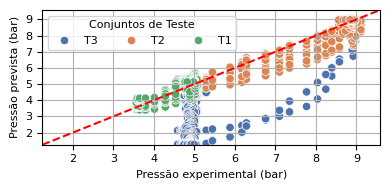

In [39]:
loss = 'mae'

fs = 8
df_list = []
for t in ['T3', 'T2', 'T1']:
    temp = predictions[loss][t].copy()
    temp['Transient'] = t
    df_list.append(temp)
combined_df = pd.concat(df_list, ignore_index=True)

# Define overall limits for the plot
overall_min = min(lims[t]['min'] for t in ['T1', 'T2', 'T3'])
overall_max = max(lims[t]['max'] for t in ['T1', 'T2', 'T3'])

# Create the single scatter plot
plt.figure(figsize=(4, 2))
plot = sns.scatterplot(data=combined_df, x='real', y='predicted', hue='Transient', palette='deep')

# Plot the reference y = x line
plt.plot([overall_min, overall_max], [overall_min, overall_max], color='red', linestyle='--')

plt.xlabel('Pressão experimental (bar)', fontsize=fs)
plt.ylabel('Pressão prevista (bar)', fontsize=fs)
plt.xlim(overall_min, overall_max)
plt.ylim(overall_min, overall_max)
plt.grid(True)
plt.legend(title='Conjuntos de Teste', loc='upper left', fontsize=fs, title_fontsize=fs, ncol=3)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout()
plt.savefig(f"figures/predictions_scatter_mae_all_in_one_{loss}.png", dpi=600)
plt.show()

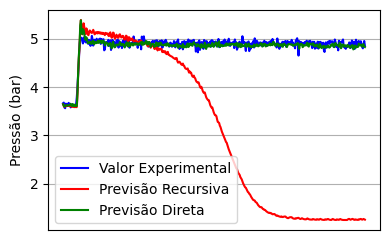

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))

for filename in os.listdir(PREDICTIONS_PATH):
    if (all(s in filename for s in ['mae', 'T3', 'Recursive', "24n"])):
        p_d = pd.read_json(os.path.join(PREDICTIONS_PATH, filename))

for filename in os.listdir(PREDICTIONS_PATH):
    if (all(s in filename for s in ['mae', 'T3', 'Direct', "24n"])):
        p_r = pd.read_json(os.path.join(PREDICTIONS_PATH, filename))


ax.plot(p_d['real']['2021-09-19 23:17:30':'2021-09-20 00:31:00'] , label='Valor Experimental', color='blue')
ax.plot(p_d['predicted']['2021-09-19 00:17:30':'2021-09-20 00:31:00'], label='Previsão Recursiva', color='red')
ax.plot(p_r['predicted']['2021-09-19 23:17:30':'2021-09-20 00:31:00'], label='Previsão Direta', color='green')
ax.set_ylabel('Pressão (bar)')
ax.xaxis.set_visible(False)
ax.grid()
ax.legend()
plt.tight_layout()

plt.savefig("figures/prediction_comparison.png", dpi=600)  # 300 is a common high-res value


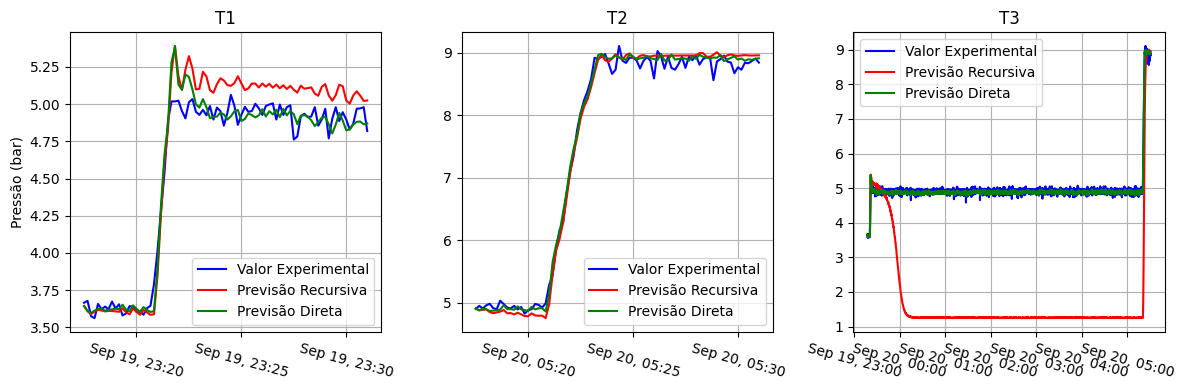

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))


for i in range(3):
    ax = axs[i]

    for filename in os.listdir(PREDICTIONS_PATH):
        if (all(s in filename for s in ['mae', f"T{i+1}", 'Recursive', "24n"])):
            p_d = pd.read_json(os.path.join(PREDICTIONS_PATH, filename))

    for filename in os.listdir(PREDICTIONS_PATH):
        if (all(s in filename for s in ['mae', f"T{i+1}", 'Direct', "24n"])):
            p_r = pd.read_json(os.path.join(PREDICTIONS_PATH, filename))


    ax.plot(p_d['real'] , label='Valor Experimental', color='blue')
    ax.plot(p_d['predicted'], label='Previsão Recursiva', color='red')
    ax.plot(p_r['predicted'], label='Previsão Direta', color='green')
    if(i == 0):
        ax.set_ylabel('Pressão (bar)')
    ax.set_title(f'T{i+1}')
    ax.tick_params(axis='x', labelsize=10, rotation=-15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))
    ax.grid()
    ax.legend()
plt.tight_layout()

plt.savefig("figures/prediction_periods_comparison.png", dpi=600)  # 300 is a common high-res value


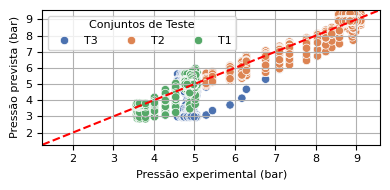

In [42]:
loss = 'mse'

fs = 8
df_list = []
for t in ['T3', 'T2', 'T1']:
    temp = predictions[loss][t].copy()
    temp['Transient'] = t
    df_list.append(temp)
combined_df = pd.concat(df_list, ignore_index=True)

# Define overall limits for the plot
overall_min = min(lims[t]['min'] for t in ['T1', 'T2', 'T3'])
overall_max = max(lims[t]['max'] for t in ['T1', 'T2', 'T3'])

# Create the single scatter plot
plt.figure(figsize=(4, 2))
plot = sns.scatterplot(data=combined_df, x='real', y='predicted', hue='Transient', palette='deep')

# Plot the reference y = x line
plt.plot([overall_min, overall_max], [overall_min, overall_max], color='red', linestyle='--')

plt.xlabel('Pressão experimental (bar)', fontsize=fs)
plt.ylabel('Pressão prevista (bar)', fontsize=fs)
plt.xlim(overall_min, overall_max)
plt.ylim(overall_min, overall_max)
plt.grid(True)
plt.legend(title='Conjuntos de Teste', loc='upper left', fontsize=fs, title_fontsize=fs, ncol=3)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout()
plt.savefig(f"figures/predictions_scatter_mae_all_in_one_{loss}.png", dpi=600)
plt.show()

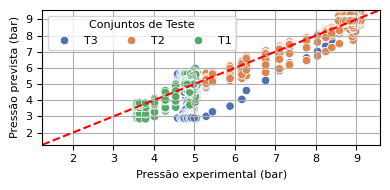

In [43]:
loss = 'huber'

fs = 8
df_list = []
for t in ['T3', 'T2', 'T1']:
    temp = predictions[loss][t].copy()
    temp['Transient'] = t
    df_list.append(temp)
combined_df = pd.concat(df_list, ignore_index=True)

# Define overall limits for the plot
overall_min = min(lims[t]['min'] for t in ['T1', 'T2', 'T3'])
overall_max = max(lims[t]['max'] for t in ['T1', 'T2', 'T3'])

# Create the single scatter plot
plt.figure(figsize=(4, 2))
plot = sns.scatterplot(data=combined_df, x='real', y='predicted', hue='Transient', palette='deep')

# Plot the reference y = x line
plt.plot([overall_min, overall_max], [overall_min, overall_max], color='red', linestyle='--')

plt.xlabel('Pressão experimental (bar)', fontsize=fs)
plt.ylabel('Pressão prevista (bar)', fontsize=fs)
plt.xlim(overall_min, overall_max)
plt.ylim(overall_min, overall_max)
plt.grid(True)
plt.legend(title='Conjuntos de Teste', loc='upper left', fontsize=fs, title_fontsize=fs, ncol=3)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout()
plt.savefig(f"figures/predictions_scatter_mae_all_in_one_{loss}.png", dpi=600)
plt.show()

### Tables division

#### MAE

In [44]:
loss = 'mae'
errors = pd.read_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss}Loss.xlsx'),
                       header=[0,1,2])
errors.columns = pd.MultiIndex.from_tuples([
    tuple("" if str(level).startswith("Unnamed") else level for level in col)
    for col in errors.columns
])

In [45]:
columns = pd.MultiIndex.from_tuples([('MAE', 'mean'), ('MAE', 'std'),
                                    ('MSE', 'mean'), ('MSE', 'std'),
                                    ('HAE', 'mean'), ('HAE', 'std'),
                                    ('MAPE', 'mean'), ('MAPE', 'std'),
                                   ])

In [46]:
index = ['Train', 'Validation']


In [47]:
agg_df = errors.groupby([('', '', "Loss")]).agg(["mean", "std"]).reset_index()

In [48]:

train_metrics = pd.DataFrame(data=[agg_df[('', 'Train')].values.flatten(),
                                    agg_df[('', 'Validation')].values.flatten()],
                                    columns=columns, index=index)
train_metrics

MAE                 MSE                 HAE            \
                mean       std      mean       std      mean       std   
Train       0.014971  0.003413  0.000548  0.000334  0.116535  0.046142   
Validation  0.017428  0.003025  0.000929  0.000514  0.177822  0.053284   

                 MAPE            
                 mean       std  
Train        4.845847  1.024574  
Validation  11.649104  4.368885

In [49]:
index = ['T1', 'T2', 'T3']

In [50]:

direct_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Direct')].values.flatten(),
                                                agg_df[('T2', 'Direct')].values.flatten(),
                                                agg_df[('T3', 'Direct')].values.flatten()],
                                                columns=columns, index=index)
direct_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.075507  0.013495  0.011621  0.004066  0.374141  0.054734  0.016466   
T2  0.094016  0.014179  0.016887  0.006608  0.384667  0.051058  0.012715   
T3  0.063537  0.008838  0.006738  0.001679  0.407703  0.044203  0.012793   

              
         std  
T1  0.003326  
T2  0.002067  
T3  0.001815

In [51]:

recursive_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Recursive')].values.flatten(),
                                                agg_df[('T2', 'Recursive')].values.flatten(),
                                                agg_df[('T3', 'Recursive')].values.flatten()],
                                                columns=columns, index=index)
recursive_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.152635  0.062489  0.039668  0.025577  0.527365  0.137586  0.032927   
T2  0.166236  0.083266  0.072440  0.093261  0.643668  0.352830  0.022561   
T3  0.495801  0.907940  1.170471  3.325881  1.105869  1.094808  0.100576   

              
         std  
T1  0.013977  
T2  0.010907  
T3  0.184567

#### MSE

In [52]:
loss = 'mse'
errors = pd.read_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss}Loss.xlsx'),
                       header=[0,1,2])
errors.columns = pd.MultiIndex.from_tuples([
    tuple("" if str(level).startswith("Unnamed") else level for level in col)
    for col in errors.columns
])

In [53]:
columns = pd.MultiIndex.from_tuples([('MAE', 'mean'), ('MAE', 'std'),
                                    ('MSE', 'mean'), ('MSE', 'std'),
                                    ('HAE', 'mean'), ('HAE', 'std'),
                                    ('MAPE', 'mean'), ('MAPE', 'std'),
                                   ])

In [54]:
index = ['Train', 'Validation']


In [55]:
agg_df = errors.groupby([('', '', "Loss")]).agg(["mean", "std"]).reset_index()

In [56]:

train_metrics = pd.DataFrame(data=[agg_df[('', 'Train')].values.flatten(),
                                    agg_df[('', 'Validation')].values.flatten()],
                                    columns=columns, index=index)
train_metrics

MAE                 MSE                 HAE            \
                mean       std      mean       std      mean       std   
Train       0.016795  0.004741  0.000635  0.000538  0.116916  0.059368   
Validation  0.019636  0.004229  0.001088  0.000714  0.183233  0.054495   

                 MAPE            
                 mean       std  
Train        5.741409  1.956622  
Validation  14.244925  5.560503

In [57]:
index = ['T1', 'T2', 'T3']

In [58]:

direct_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Direct')].values.flatten(),
                                                agg_df[('T2', 'Direct')].values.flatten(),
                                                agg_df[('T3', 'Direct')].values.flatten()],
                                                columns=columns, index=index)
direct_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.084647  0.024225  0.014885  0.008290  0.433426  0.099431  0.018523   
T2  0.096917  0.020322  0.018266  0.009094  0.406769  0.058946  0.013103   
T3  0.071054  0.024524  0.008642  0.005854  0.454111  0.086236  0.014344   

              
         std  
T1  0.005532  
T2  0.002937  
T3  0.005023

In [59]:

recursive_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Recursive')].values.flatten(),
                                                agg_df[('T2', 'Recursive')].values.flatten(),
                                                agg_df[('T3', 'Recursive')].values.flatten()],
                                                columns=columns, index=index)
recursive_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.181422  0.093411  0.065782  0.064851  0.725194  0.225653  0.039854   
T2  0.176023  0.095473  0.064411  0.078130  0.569398  0.264188  0.023668   
T3  0.202185  0.257512  0.115841  0.480498  0.783839  0.320646  0.040933   

              
         std  
T1  0.021065  
T2  0.012120  
T3  0.052415

#### HUBER

In [60]:
loss = 'huber'
errors = pd.read_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss}Loss.xlsx'),
                       header=[0,1,2])
errors.columns = pd.MultiIndex.from_tuples([
    tuple("" if str(level).startswith("Unnamed") else level for level in col)
    for col in errors.columns
])

In [61]:
columns = pd.MultiIndex.from_tuples([('MAE', 'mean'), ('MAE', 'std'),
                                    ('MSE', 'mean'), ('MSE', 'std'),
                                    ('HAE', 'mean'), ('HAE', 'std'),
                                    ('MAPE', 'mean'), ('MAPE', 'std'),
                                   ])

In [62]:
index = ['Train', 'Validation']


In [63]:
agg_df = errors.groupby([('', '', "Loss")]).agg(["mean", "std"]).reset_index()

In [64]:

train_metrics = pd.DataFrame(data=[agg_df[('', 'Train')].values.flatten(),
                                    agg_df[('', 'Validation')].values.flatten()],
                                    columns=columns, index=index)
train_metrics

MAE                 MSE                 HAE            \
                mean       std      mean       std      mean       std   
Train       0.016560  0.004628  0.000610  0.000524  0.113195  0.057519   
Validation  0.019354  0.003807  0.001037  0.000656  0.178727  0.053041   

                 MAPE            
                 mean       std  
Train        5.636975  1.904645  
Validation  13.904287  4.548958

In [65]:
index = ['T1', 'T2', 'T3']

In [66]:

direct_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Direct')].values.flatten(),
                                                agg_df[('T2', 'Direct')].values.flatten(),
                                                agg_df[('T3', 'Direct')].values.flatten()],
                                                columns=columns, index=index)
direct_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.083146  0.023501  0.014176  0.007722  0.425691  0.098726  0.018190   
T2  0.095609  0.020186  0.017813  0.008998  0.402263  0.057871  0.012923   
T3  0.070594  0.024730  0.008523  0.005901  0.449920  0.083875  0.014249   

              
         std  
T1  0.005321  
T2  0.002924  
T3  0.005065

In [67]:

recursive_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Recursive')].values.flatten(),
                                                agg_df[('T2', 'Recursive')].values.flatten(),
                                                agg_df[('T3', 'Recursive')].values.flatten()],
                                                columns=columns, index=index)
recursive_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.170832  0.089349  0.060017  0.061709  0.704088  0.211804  0.037632   
T2  0.165057  0.088307  0.056594  0.073141  0.545957  0.254784  0.022282   
T3  0.192518  0.267806  0.117244  0.526047  0.758596  0.320545  0.038988   

              
         std  
T1  0.020085  
T2  0.011408  
T3  0.054510